In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import glob
import pandas as pd
from textblob import TextBlob
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import *
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import *
conn = sqlite3.connect('/content/drive/MyDrive/table.db')
c = conn.cursor()

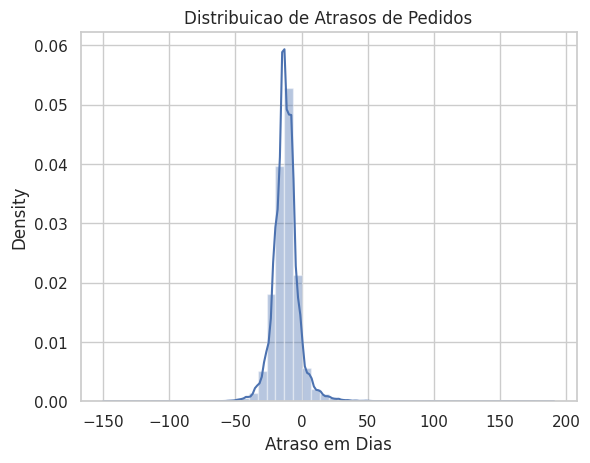

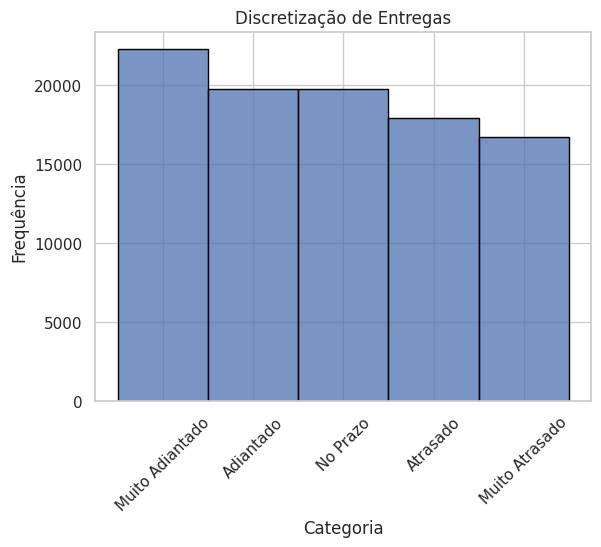

In [37]:
c.execute('SELECT order_delivered_customer_date, order_estimated_delivery_date FROM orders;')
rows = c.fetchall()
reais = []
estimadas = []
for i in rows:
  real = i[0]
  estimada = i[1]
  if not real is None:
    data = real.split()[0]
    hora = real.split()[1]
    datahora = f"{data} {hora}"
    reais.append(datetime.strptime(datahora, '%Y-%m-%d %H:%M:%S'))

    data = estimada.split()[0]
    hora = estimada.split()[1]
    datahora = f"{data} {hora}"
    estimadas.append(datetime.strptime(datahora, '%Y-%m-%d %H:%M:%S'))


contador = 0
res = []
media = 0
for i in range(len(reais)):  
  res.append(int((reais[i] - estimadas[i]).days))
  contador += 1
  
  media += res[-1]

sns.set(style="whitegrid", color_codes=True)
res = np.array(res)
sns.distplot(res)
plt.xlabel('Atraso em Dias')
plt.title('Distribuicao de Atrasos de Pedidos')
plt.show()

binss = ['Muito Adiantado', 'Adiantado', 'No Prazo', 'Atrasado', 'Muito Atrasado']
res = pd.qcut(res, 5, labels=binss)
sns.histplot(data=res, stat="count", edgecolor='black')
plt.xlabel('Categoria')
plt.ylabel('Frequência')
plt.title('Discretização de Entregas')
plt.xticks(rotation=45)
plt.show()

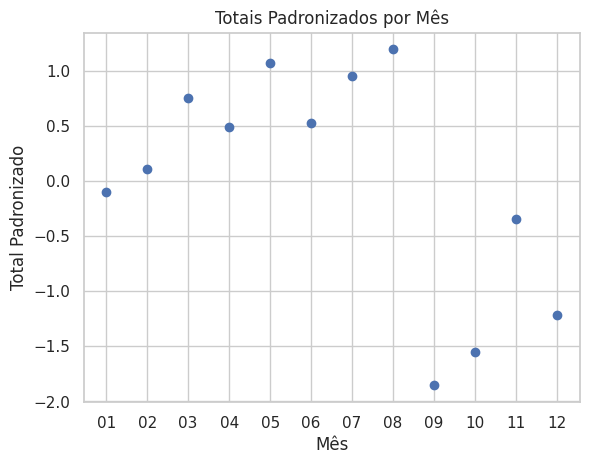

In [39]:
c.execute("SELECT strftime('%m', order_purchase_timestamp) AS mes, COUNT(*) AS total FROM orders GROUP BY mes;")
resultado = c.fetchall()

totais = [linha[1] for linha in resultado]

media = np.mean(totais)
desvio_padrao = np.std(totais)

totais_padronizados = [(x - media) / desvio_padrao for x in totais]

meses = [linha[0] for linha in resultado]

plt.scatter(meses, totais_padronizados)
plt.xlabel('Mês')
plt.ylabel('Total Padronizado')
plt.title('Totais Padronizados por Mês')
plt.show()

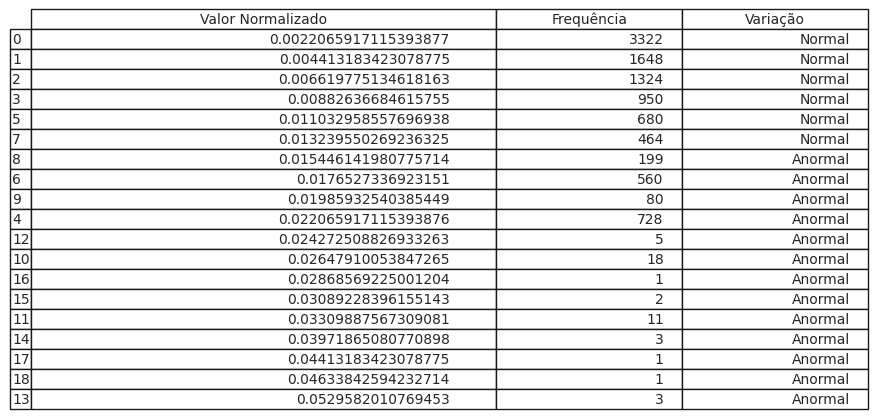


Somatório das frequências onde a variação foi anormal: 1612.


In [32]:
c.execute("SELECT payment_installments FROM order_payments WHERE payment_type = 'credit_card' LIMIT 10000;")

parcelas = []

for i in c.fetchall():
    parcelas.append(i[0])

parcelas = np.array(parcelas)
parcelas = normalize([parcelas])[0]

desvio_padrao = np.std(parcelas)
media = np.mean(parcelas)


tabela_frequencias = pd.Series(parcelas).value_counts().reset_index()
tabela_frequencias.columns = ['Valor Normalizado', 'Frequência']
tabela_frequencias = tabela_frequencias.sort_values('Valor Normalizado')

limite_superior = media + 1 * desvio_padrao

tabela_frequencias['Variação'] = tabela_frequencias['Valor Normalizado'].apply(
    lambda x: 'Anormal' if x > limite_superior else 'Normal')

frequencias_alta = tabela_frequencias[tabela_frequencias['Variação'] == 'Anormal']['Frequência'].sum()

fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('off')

tabla = pd.plotting.table(ax, tabela_frequencias, loc='center', colWidths=[0.5, 0.2, 0.2])
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(2, 1.2)

plt.show()
print(f"\nSomatório das frequências onde a variação foi anormal: {frequencias_alta}.")

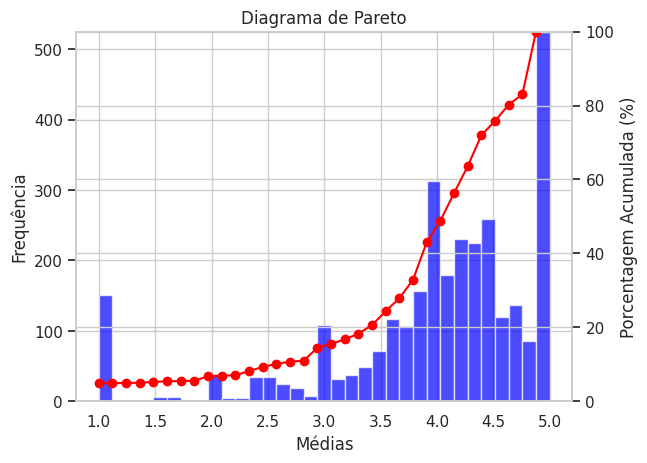


De 3090, 510 vendedores possuem uma avaliação muito acima da média e 445 possuem uma avalição muito abaixo da média.


In [33]:
c.execute("SELECT AVG(orv.review_score) AS average_review_score FROM sellers s JOIN order_items oi ON s.seller_id = oi.seller_id JOIN order_reviews orv ON oi.order_id = orv.order_id GROUP BY s.seller_id;")
resultado = c.fetchall()

desvio_padrao = np.std(resultado)
media = np.mean(resultado)

conx = 0 
cony = 0

for x in resultado:
  if (x < media - 1 * desvio_padrao):
    conx+=1

for y in resultado:
  if (y > media + 1 * desvio_padrao):
    cony+=1

conexao = sqlite3.connect('/content/drive/MyDrive/table.db')
cursor = conexao.cursor()

consulta_sql = "SELECT AVG(orv.review_score) AS average_review_score FROM sellers s JOIN order_items oi ON s.seller_id = oi.seller_id JOIN order_reviews orv ON oi.order_id = orv.order_id GROUP BY s.seller_id;"
cursor.execute(consulta_sql)

resultado = cursor.fetchall()
resultado = np.array(resultado)  # Converter para um array NumPy

desvio_padrao = np.std(resultado)
media = np.mean(resultado)

# Calcular frequências
frequencias, bins = np.histogram(resultado, bins='auto')

# Calcular frequências acumuladas e porcentagem acumulada
frequencias_acumuladas = np.cumsum(frequencias)
porcentagens_acumuladas = (frequencias_acumuladas / frequencias_acumuladas[-1]) * 100

# Plotar o gráfico de Pareto
fig, ax1 = plt.subplots()

# Gráfico de barras
ax1.bar(bins[:-1], frequencias, align='edge', width=np.diff(bins), alpha=0.7, color='blue')
ax1.set_xlabel('Médias')
ax1.set_ylabel('Frequência')
ax1.set_ylim([0, max(frequencias) + 1])

# Gráfico de linha (porcentagem acumulada)
ax2 = ax1.twinx()
ax2.plot(bins[:-1], porcentagens_acumuladas, '-o', color='red')
ax2.set_ylabel('Porcentagem Acumulada (%)')
ax2.set_ylim([0, 100])

plt.title('Diagrama de Pareto')
plt.show()

print(f'\nDe {len(resultado)}, {cony} vendedores possuem uma avaliação muito acima da média e {conx} possuem uma avalição muito abaixo da média.')

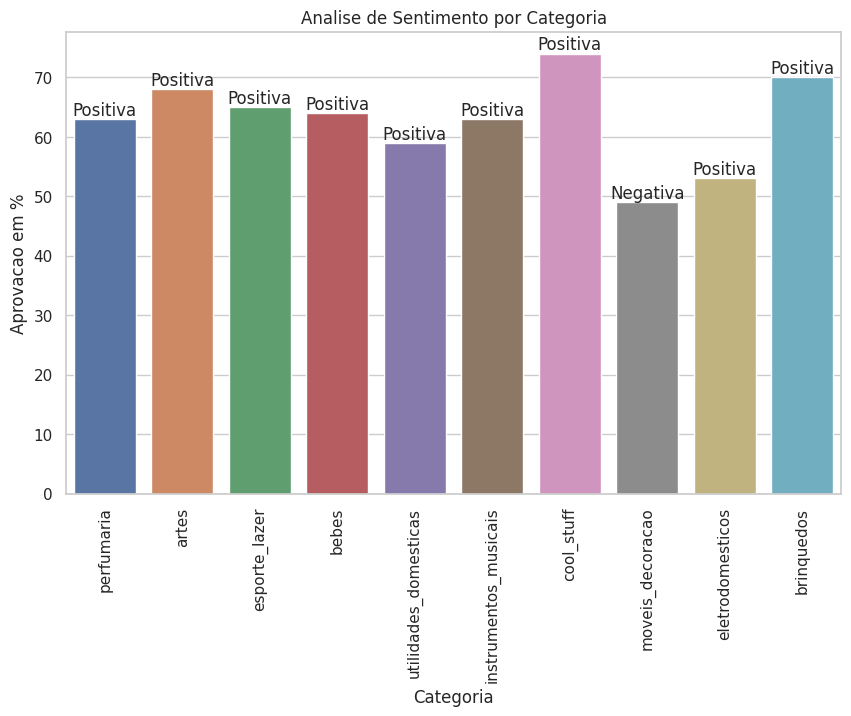

In [34]:
c.execute('SELECT product_category_name FROM products limit 10;')
rows = c.fetchall()
categorias = []
for i in rows:
  categorias.append(i[0])

res = []
conclusao = []
for i in categorias:
  sentimentos = []
  c.execute(f"SELECT review_comment_message FROM order_reviews join order_items on order_items.order_id = order_reviews.order_id join products on products.product_id = order_items.product_id where review_comment_message is not NULL and product_category_name = '{i}' limit 5;")
  rows = c.fetchall()
  for j in rows:
    blob = TextBlob(j[0])
    try:
      blob = blob.translate(from_lang='pt',to='en')
    except:
      pass
    
    sentimentos.append(blob.sentiment.polarity + 1)

  if len(sentimentos) > 0:
    media_sentimentos = sum(sentimentos) / len(sentimentos)
  else:
    media_sentimentos = 0
    
  res.append(int((media_sentimentos * 100) / 2))

  if res[-1] > 50:
      conclusao.append("Positiva")
  elif res[-1] < 50:
      conclusao.append("Negativa")
  else:
      conclusao.append("Neutra")


df = pd.DataFrame({'X': categorias, 'Y': res, 'Inside': conclusao})

sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='X', y='Y', data=df, ax=ax)

for i, bar in enumerate(ax.patches):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            df['Inside'][i], ha='center', va='bottom')

plt.ylabel('Aprovacao em %')
plt.xlabel('Categoria')
plt.title('Analise de Sentimento por Categoria')
plt.xticks(rotation=90)
plt.show()
